# Precipitation Forecasting for Caribbean Region with SARIMA 

In this jupyter notebook, we will build the SARIMA model by choosing the parameters manually instead of using Auto ARIMA. The Auro Arima gave us very poor forecasts in the previous section. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

from pmdarima import auto_arima

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#First, let's import out dataset

# Load the dataset

from utils import load_caribbean_weather

df = load_caribbean_weather()

In [3]:
df_p = df[['precip_log']]
df_p.describe()

,precip_log
count,550.000000
mean,5.615290
std,1.011371
min,3.272606
25%,4.813796
50%,5.868039
75%,6.500236
max,7.082775


## Autocorrelation Function
measures correlation between the precipitation series and its past values (lags).

<Figure size 1200x600 with 0 Axes>

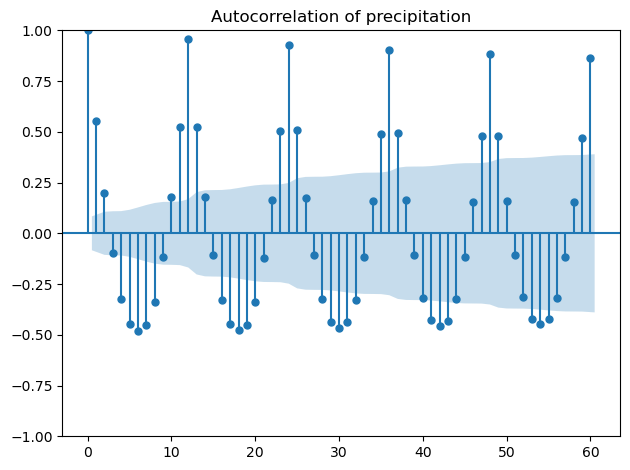

In [6]:
plt.figure(figsize=(12,6))
plot_acf(df_p, lags=60, title='Autocorrelation of precipitation')
plt.tight_layout()
plt.show()

Key Observations:

*High correlation at lags 1, 13, 25 and etc*, these lags have strong positive correlations, indicating that this month's precipitation is roughly influenced by precipitation of the whole year. 
*Periodic Spikes*, notice the regular spikes at approximately 12 months, suggesting 1-year seasonality. This periodic behavior confirms that precipitation patterns repeates every year.
*Gradual Decay*, the autocorrelation gradually decreases as the lag features increase, indicating that the relationship between present and past weakens over time. This suggests a combination of *trend and seasonality* in the data.
Most lags within the 12 month period are significant (outside the shaded confidence interval), reinforcing the presence of structured 1-year seasonality.

## Partial Autocorrelation Function
measures correlation between the series and its lagged values.

<Figure size 1200x600 with 0 Axes>

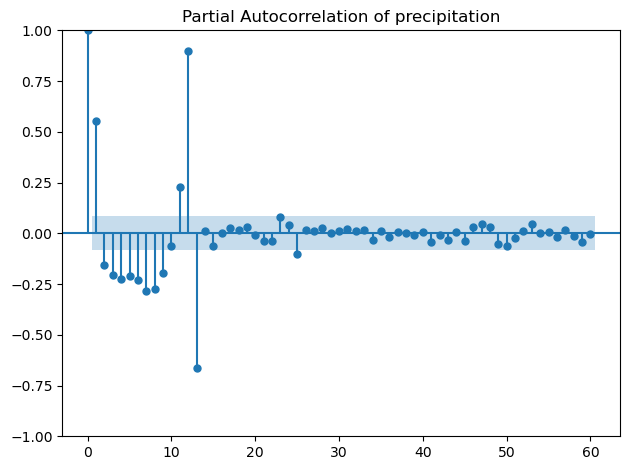

In [7]:
plt.figure(figsize=(12,6))
plot_pacf(df_p, lags=60, title='Partial Autocorrelation of precipitation')
plt.tight_layout()
plt.show()

Key Observations:

*Significant Lags 1 and 13*, indicating a strong direct relationship between this month's temperature anomaly and those of the whole year before. There is a significant drop-off after lag=14, indicating that the influence of past weather is limited to approximately 12-14 months. 

## Decomposition and Stationary Plots

The model type is determined to be *additive* based on the nature of seasonal fluctuations. From the ACF/PACF analysis, periodic spikes at 12 months indicate 1-year long seasonality. Thus, a period of 12 is used for decomposition. We will actually try using 12 and 14 months periodicity.

In [8]:
df_p.head()

,precip_log
date,
1980-01-01,3.819688
1980-02-01,4.382901
1980-03-01,4.610953
1980-04-01,5.054014
1980-05-01,5.552611


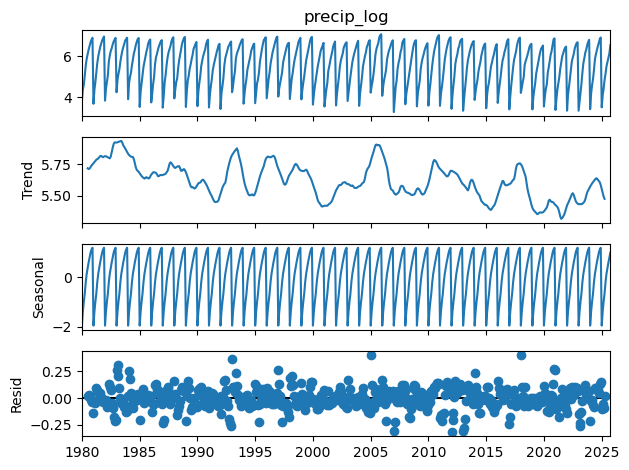

In [14]:
decomposition_1_year = seasonal_decompose(df_p['precip_log'], period=12, model='additive')
decomposition_1_year.plot()
plt.show()

## Check for Stationarity: Augmented Dickey-Fuller (ADF) test

While ACF plot suggests non-stationarity, if we want to confirm it formaly, we need to use the Augmented Dickey-Fuller (ADF) test. 

In [15]:
result = adfuller(df_p['precip_log'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -4.758844072999672
p-value: 6.515196348272017e-05
Critical Value (1%): -3.4426552678216003
Critical Value (5%): -2.8669676577777548
Critical Value (10%): -2.569660749624767


In [16]:
from statsmodels.tsa.stattools import kpss
print("Results of KPSS Test:")
kpsstest = kpss(df_p['precip_log'], regression="c", nlags="auto")
kpss_output = pd.Series(
    kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
)
for key, value in kpsstest[3].items():
    kpss_output["Critical Value (%s)" % key] = value
print(kpss_output)

Results of KPSS Test:
Test Statistic           0.223309
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Based upon the statistical level of 0.05 and p-value of both ADF test and KPSS test, the null hypothesis cannot be rejected. Hence the series is non-stationary.

Next steps include differencing the series: we will employ two approaches (removing trend and removing seasonality)

ADF Statistic after Differencing: -8.2263
p-value after Differencing: 0.0


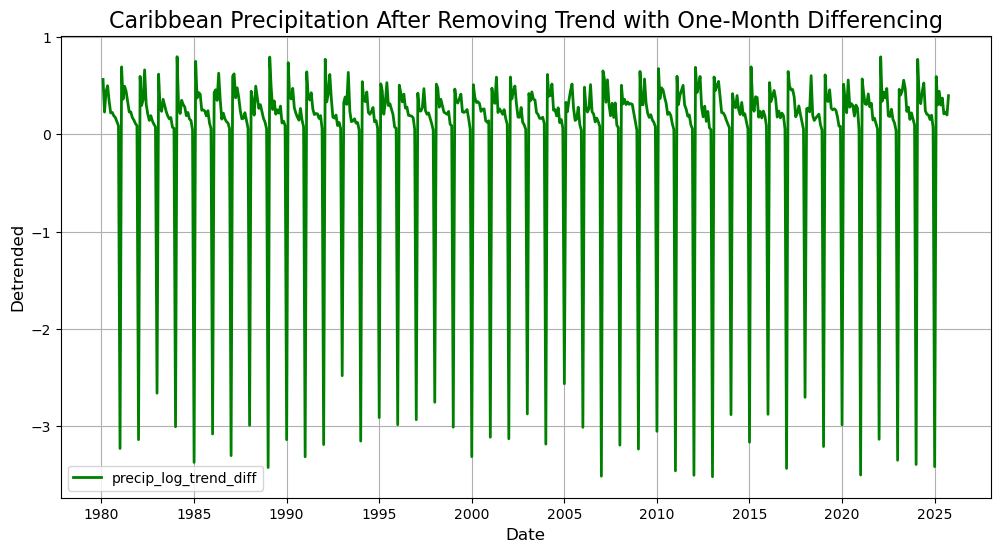

In [17]:
#Regular Differencing for trend removal
df_p['precip_log_trend_diff'] = df['precip_log'].diff().dropna()

result_diff = adfuller(df_p['precip_log_trend_diff'].dropna())
print("ADF Statistic after Differencing:", result_diff[0].round(4))
print("p-value after Differencing:", result_diff[1].round(4))


#The plot after removing trend to check stationarity
plt.figure(figsize=(12, 6))
plt.plot(df.index, df_p['precip_log_trend_diff'], label='precip_log_trend_diff', linewidth=2, color='green')
plt.title('Caribbean Precipitation After Removing Trend with One-Month Differencing', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Detrended', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

ADF Statistic after Differencing: -6.4597
p-value after Seasonal Differencing: 0.0


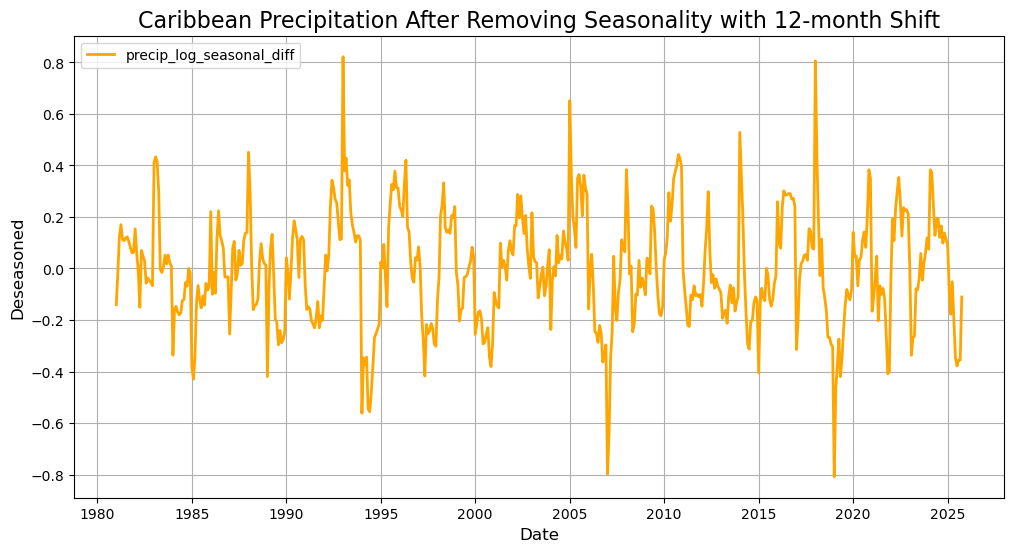

In [18]:
#Seasonal Differencing for Seasonality removal
df_p['precip_log_seasonal_diff'] = df['precip_log'] - df['precip_log'].shift(12) #t-12 

result_diff_seasonal = adfuller(df_p['precip_log_seasonal_diff'].dropna())
print("ADF Statistic after Differencing:", result_diff_seasonal[0].round(4))
print("p-value after Seasonal Differencing:", result_diff_seasonal[1].round(4))

plt.figure(figsize=(12, 6))
plt.plot(df.index, df_p['precip_log_seasonal_diff'], label='precip_log_seasonal_diff', linewidth=2, color='orange')
plt.title('Caribbean Precipitation After Removing Seasonality with 12-month Shift', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Deseasoned', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

### Auto ARIMA for parameters

We will run an auto arima to choose the most efficient parameters based on AIC metric.

In [19]:
# First, we will split the precipitation dataset into training and testing sets

train = df_p[:-12] 
test = df_p[-12:]

In [23]:
# Fit auto_arima function to caribbean temp dataset
arima_model = auto_arima(train['precip_log'], start_p = 0, d = 1, start_q = 0,
                          max_p = 5, max_d = 5, max_q = 5, m = 12,
                          start_P = 0, start_Q = 0, max_P = 5, 
                          max_D = 5, max_Q = 5, seasonal = True,
                          D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# To print the summary
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-533.160, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-729.220, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-539.048, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-751.605, Time=0.66 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-787.460, Time=1.36 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-818.463, Time=2.12 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-821.576, Time=3.67 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=-819.715, Time=7.41 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=7.15 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=-818.054, Time=2.48 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=-822.113, Time=5.16 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=-818.577, Time=3.17 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=-820.177, Time=11.18 sec
 ARIMA(2,1,0)(4,1,1)[12]    

KeyboardInterrupt: 

## The SARIMA Model

This step involves fitting the SARIMA model to the data and evaluating its performance. The parameters are those suggested by the auto-arima above.

In [24]:
# Parameters
p, d, q = 0, 1, 0  # Non-seasonal ARIMA parameters
P, D, Q, m = 0, 1, 0, 12  # Seasonal parameters with weekly seasonality (m=7)


from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train['precip_log'],
    order=(p, d, q),              #Non-seasonal parameters
    seasonal_order=(P, D, Q, m),  #Seasonal parameters (48 mo seasonality)
    enforce_stationarity=False,   #False since differencing (d and D) already handles non-stationarity
    enforce_invertibility=False   #Allow temporarily violate invertibility during optimization
)

sarima_fit = model.fit(disp=False)
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         precip_log   No. Observations:                  538
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 266.964
Date:                            Tue, 09 Dec 2025   AIC                           -531.929
Time:                                    22:25:43   BIC                           -527.667
Sample:                                01-01-1980   HQIC                          -530.260
                                     - 10-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0211      0.001     30.748      0.000       0.020       0.022
===================================================================================
Ljung-Box (L1) (Q):                   8.08   Jarque-Bera (JB):               595.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.12
Prob(H) (two-sided):                  0.51   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

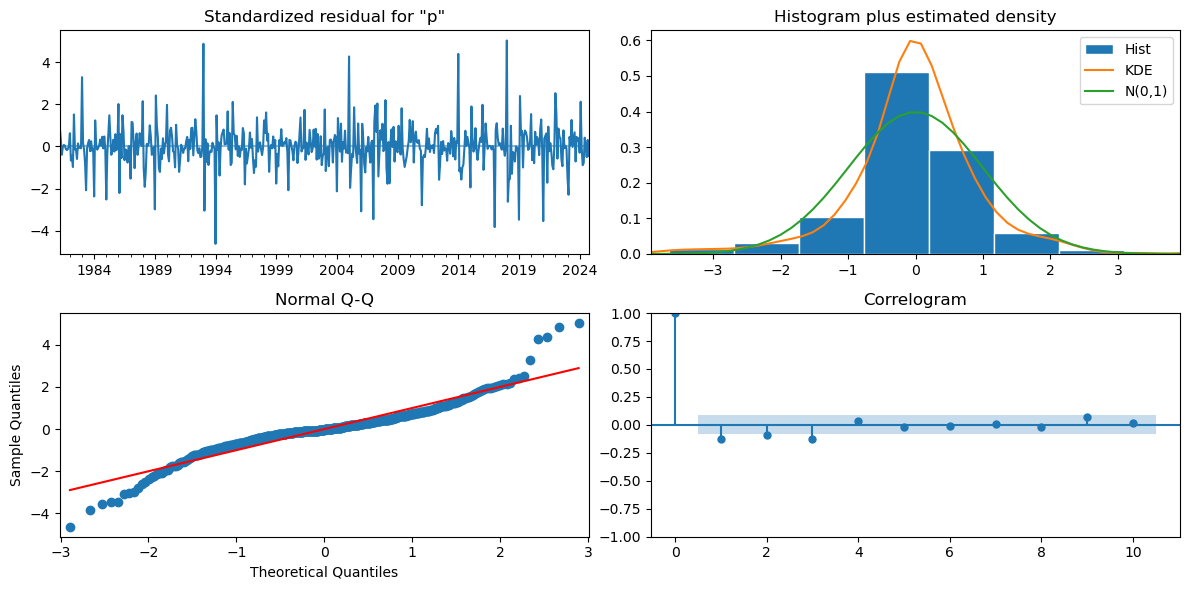

In [25]:
sarima_fit.plot_diagnostics(figsize=(12,6))
plt.tight_layout()

### Forecasting Precipitation

In this section we will perform precipitation forecsting using the previously built SARIMAX(0, 1, 0)x(0, 1, 0, 12) model. We divided the dataset into training (all but the last year) and testing set (last year until Oct 2025). The model is trained on the training set, and its performance is validated on the test set using evaluation metrics such as RMSE (Root Mean Square Error) and MAE (Mean Absolute Error). Finally, we use the model to forecast the next 12 months to show its predictive capability.

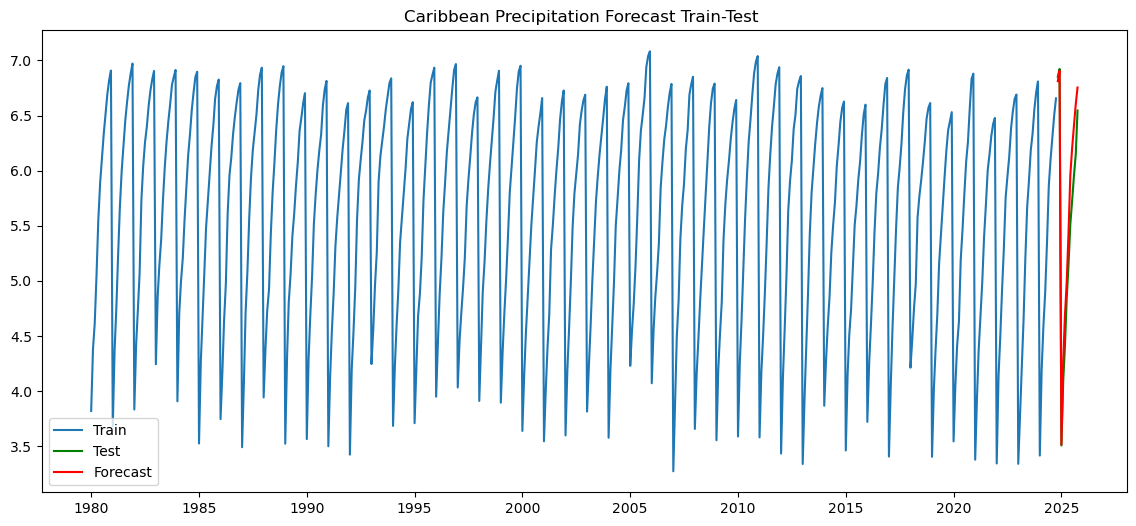

In [26]:
forecast_test = sarima_fit.forecast(steps=12)
forecast_test.index = test.index

plt.figure(figsize=(14, 6))
plt.plot(train['precip_log'], label='Train')
plt.plot(test['precip_log'], label='Test', color='green')
plt.plot(forecast_test, label='Forecast', color='red')
plt.title('Caribbean Precipitation Forecast Train-Test ')
plt.legend()
plt.show()

### Forecast Evaluation

The forecasted results (red line) aligns well with the test data (green line). The Sarimax model was trained using 12 months seasonality feature, 12-mo feature was the most efficient with AIC = 531.

Evaluation Statistics of the SARIMAX Model with parameters ARIMA(0,1,0)(0,1,0)[12]

- Mean Absolute Error = 0.25001572047467
- Mean Squared Error =  0.09163582249059053
- Root Mean Squared Error (RMSE) = 0.3027140936438053
- The r2_score  = 0.9173807467921815

On average, the model performed very well with MAE=0.25, meaning that the model's predictions are approaximately 0.2 mm away from the true values. 
r2 score of 0.92 means that our model's explained approximately 92% of data. 
RMSE of 0.30 means that model's predictions have an error of 0.30 mm.


In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

true_values = test['precip_log']
predicted_values = forecast_test

print(f'Evaluation Statistics of the SARIMAX Model with parameters ARIMA(0,1,0)(0,1,0)[12]')

mae = mean_absolute_error(true_values, predicted_values)
print(f'Mean Absolute Error = {mae}')

mse = mean_squared_error(true_values, predicted_values)
print(f'Mean Squared Error =  {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) = {rmse}')

score = r2_score(true_values, predicted_values)
print(f'The r2_score  = {score}')

Evaluation Statistics of the SARIMAX Model with parameters ARIMA(0,1,0)(0,1,0)[12]
Mean Absolute Error = 0.25001572047467
Mean Squared Error =  0.09163582249059053
Root Mean Squared Error (RMSE) = 0.3027140936438053
The r2_score  = 0.9173807467921815


### Real Forecast (for 12 months)

In [28]:
# Train on the whole dataset for forecasting

model = SARIMAX(
    df_p['precip_log'],
    order=(0, 1, 0),              #Non-seasonal parameters
    seasonal_order=(0, 1, 0, 12),  #Seasonal parameters (48 mo seasonality)
    enforce_stationarity=False,   #False since differencing (d and D) already handles non-stationarity
    enforce_invertibility=False   #Allow temporarily violate invertibility during optimization
)

sarima_fit = model.fit(disp=False)
sarima_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         precip_log   No. Observations:                  550
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 275.219
Date:                            Tue, 09 Dec 2025   AIC                           -548.439
Time:                                    22:35:34   BIC                           -544.155
Sample:                                01-01-1980   HQIC                          -546.763
                                     - 10-01-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0210      0.001     31.035      0.000       0.020       0.022
===================================================================================
Ljung-Box (L1) (Q):                   7.87   Jarque-Bera (JB):               602.58
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.13
Prob(H) (two-sided):                  0.42   Kurtosis:                         8.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
from dateutil.relativedelta import relativedelta

forecast_steps = 12
forecast = sarima_fit.forecast(steps=forecast_steps)
#Creating a date range for the forecast
future_dates = pd.date_range(start=df.index[-1] + relativedelta(months=1),periods=forecast_steps,freq='MS')

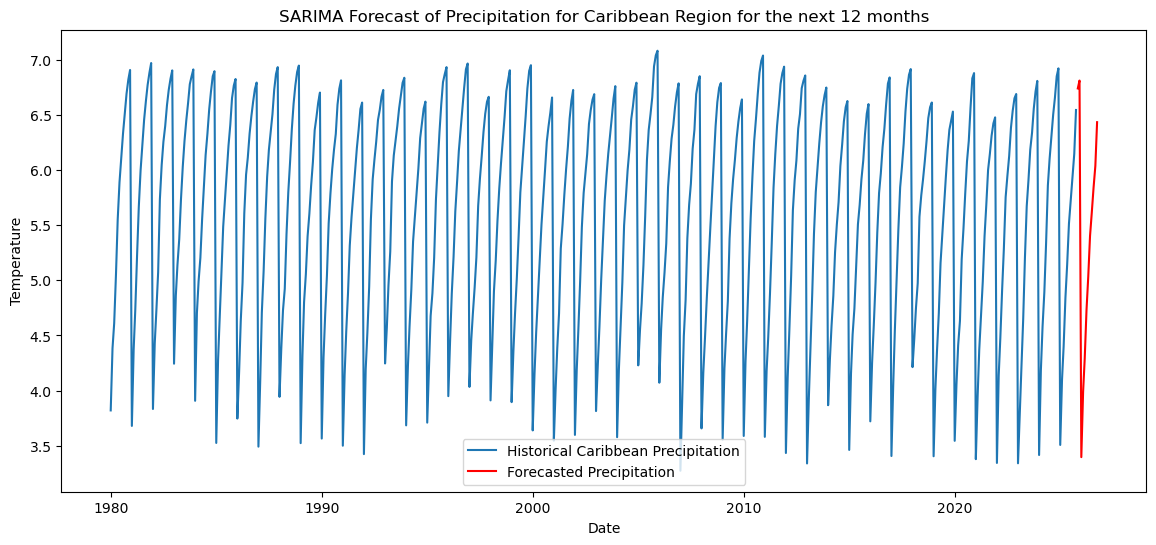

In [31]:

#Creating a forecast series
forecast_series = pd.Series(forecast, index=future_dates)

plt.figure(figsize=(14, 6))
plt.plot(df_p['precip_log'], label='Historical Caribbean Precipitation')
plt.plot(forecast_series, label='Forecasted Precipitation', color='red')
plt.title('SARIMA Forecast of Precipitation for Caribbean Region for the next 12 months')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

### Forecast Notes

Our prediction for the next year for the Caribbean Region, as shown in the plot in red, serves as baseline supportive tool for forecasting precipitation and making informative decisions based on expected trends and patterns.